**TO DO:** Make a copy of this notebook in your own Google drive and edit the copy.

**TO DO:** Download the data at the following link https://stanfordmlgroup.github.io/competitions/mrnet/ and upload it to your Google Drive. 

This will download a folder named 'data'. 

*   The dataset consists of 1,250 knee MRIs with image level labels.
*   The training data consists of 1,130 MRIs and the validation data consists of 120 MRIs.
*   They are labelled as abnormal, having an acl tear and/or meniscus tear.
*   Each MRI exam includes data from the axial, coronal and sagittal plane. 
*   Axial is a Proton-Density series, coronal is a T1-weighted series and sagittal is T2-weighted series.






Go to "Edit" on the toolbar, then "Notebook Settings" and change the hardware accelerator to GPU.


#Mount Google Drive to access your data



In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


The following code uses a python library named 'torchsample'. This is not installed in Google Colab. We can import it by running the commands in the following cell. The exclamation mark communicates to Google Colab to run the commands in the terminal rather than in Python in the current notebook.


In [2]:
!pip install -e git+https://github.com/ncullen93/torchsample.git#egg=torchsample
!pip install visdom
!pip install nibabel
!pip install h5py  
!pip install torchsample
!pip install tensorboardX

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining torchsample from git+https://github.com/ncullen93/torchsample.git#egg=torchsample
  Cloning https://github.com/ncullen93/torchsample.git to ./src/torchsample
  Running command git clone -q https://github.com/ncullen93/torchsample.git /content/src/torchsample
  Running setup.py develop for torchsample
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 676 kB 4.2 MB/s 
     |████████████████████████████████| 54 kB 3.3 MB/s 
  Created wheel for visdom: filename=visdom-0.1.8.9-py3-none-any.whl size=655250 sha256=8dddd5ff5f8609bafb632878c6df265a6d0373317a3cb75ee0cebe8d2d9661fa
  Stored in directory: /root/.cache/pip/wheels/2d/d1/9b/cde923274eac9cbb6ff0d8c7c72fe30a3da9095a38fd50bbf1
  Created wheel for torchfile: filename=torchfile-0.1.0-py3-none-any.whl size=5709 sha256=9733051d069149967b852a6d1c2

In [3]:
#import all libraries
import torch.optim as optim
import torch
import torch.nn as nn
from torchvision import models
import numpy as np
import os
import sys
import pickle
import torch.nn.functional as F
import torch.utils.data as data
import pandas as pd
from torch.autograd import Variable
from src.torchsample.torchsample.transforms import RandomRotate, RandomTranslate, RandomFlip, ToTensor, Compose, RandomAffine
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter
import math
from sklearn import metrics

#Define your model
The model is defined in the class 'Net'. The 'init' function initialises the architecture of the model.

The line of code; ```self.pretrained_model = None``` should be edited to initialise a pre-trained model, pre-trained on the ImageNet Dataset. This initialises the weights of the model with the weights for a pre-trained model that was trained on the ImageNet dataset. This speeds up training.

The line of code ```self.classifer = None``` should be edited to be a fully connected layer that makes the final prediction.

After the model is initialised, the forward function is called iteratively throughout the training process. 

More information con defining models can be found at https://pytorch.org/vision/stable/models.html

##Fill in None values

In [4]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.pretrained_model =  nn.Sequential(*list(models.resnet18(pretrained=True).children())[:-1]  )
        self.classifer = nn.Linear(512, 1)

    
    def forward(self, x):
        # input size of x (1, s, 3, 256, 256) where s is the number of slices in one MRI
        x = torch.squeeze(x, dim=0) #output size (s, 3, 256, 256)
        x = self.pretrained_model(x) #input to pretrained model, output size (s, 1000)
        output = torch.max(x, 0, keepdim=True)[0] #output size (1, 512)
        output = self.classifer(output.squeeze(2).squeeze(2)) #output size (1)
        return output

#Create Dataloader
The 'init' function initialises the dataloader. This class is responsible for loading the datasets. It takes the 'root_dir', 'task', 'plane', 'train' and 'transform' as input parameters. 
root_dir - the directory to where the data is stored.

task - whether the model is being trained to detect acl tears, meniscus tears or abnormalities. Possible values are 'acl', 'meniscus' or 'abnormal'.

plane - whether the model is being trained on axial, coronal or sagittal data. Possible values are 'axial', 'coronal' or 'sagittal'.

train - is this the dataloader for the training data or the validation data. Possible values are 'True' to load training data or 'False' to load validation data.

transform - a compose function for performing transformations to the images.

The init function creates 1) a list of paths to each MRI, 2) a corresponding list of labels that are either ones or zeros and 3) weights.


---



The __len__ function returns the length of the dataset.


---
The __getitem__ function is iteratively called throughout the training process. It takes an index as a input parameter. It loads the MRI at the given index from the list of paths defined in the init function. It also returns the label and weight for the MRI at that index.



In [5]:
class Dataset(data.Dataset):
    def __init__(self, root_dir, task, plane, train=False, transform=None):
        super().__init__()
        self.task = task
        self.plane = plane
        self.root_dir = root_dir
        self.train=train
        if self.train == True:
            self.folder_path = self.root_dir + 'train/{0}/'.format(plane)
            self.records = pd.read_csv(
                self.root_dir + 'train-{0}.csv'.format(task), header=None, names=['id', 'label'])
        else:
            self.folder_path = self.root_dir + 'valid/{0}/'.format(plane)

            self.records = pd.read_csv(
                self.root_dir + 'valid-{0}.csv'.format(task), header=None, names=['id', 'label'])

        self.records['id'] = self.records['id'].map(
            lambda i: '0' * (4 - len(str(i))) + str(i))
        self.paths = [self.folder_path + filename +
                      '.npy' for filename in self.records['id'].tolist()]
        self.labels = self.records['label'].tolist()

        self.transform = transform
        
        pos = np.sum(self.labels)
        neg = len(self.labels) - pos
        self.weights = [1, neg / pos]
        

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        array = np.load(self.paths[index]) #load MRI 
        label = self.labels[index] #get label of MRI
        label = torch.FloatTensor([label]) #convert type from numpy to torch

        if self.transform: #if you are transforming it
            array = self.transform(array) #transform the image
            array = array.numpy()


        array = np.stack((array,)*3, axis=1) #the model expects dimensions of (3, 256, 256), the MRIs are greyscale of size (256, 256). Therefore, we stack the image three times to fit the dimensions for the model.
        array = torch.FloatTensor(array)

        if label.item() == 1:
            weight = np.array([self.weights[1]])
            weight = torch.FloatTensor(weight)
        else:
            weight = np.array([self.weights[0]])
            weight = torch.FloatTensor(weight)

        return array, label, weight

#Train the model
##Define variables
**TO DO:** Change directory to where you store your data. Use the toolbar to the side of this page to view your file system.

In [13]:
directory='./gdrive/MyDrive/MRNet-v1.0/' #directory to the data
task = 'acl'
plane = 'sagittal'
lr = 1e-5 #learning rate
num_epochs = 20 # number of epochs

##Initialise the model, optimiser, scheduler, transformations and data loader.

##Fill in the 'None' values

In [7]:
model = Net() #initialise the model
if torch.cuda.is_available(): #if there is a GPU available, put the model on the GPU
    model = model.cuda()

optimizer = optim.Adam(model.parameters(), lr= lr, weight_decay=0.1) #define the optimiser as Adam

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, patience=4, factor=.3, threshold=1e-4, verbose=True) #define a scheduler that decreases the learning rate if there has been no reduction in validation loss is four epochs

#define a compose function that is a series of transformations on the images. 
augmentor = Compose([ 
            transforms.Lambda(lambda x: torch.Tensor(x)), #converts from numpy to tensor
            RandomRotate(25), #rotate the image by 25 degrees
            RandomTranslate([0.11, 0.11]), #blur the edges
            RandomFlip(), #flip the image
        ])

# Writer will output to ./runs/ directory by default
writer = SummaryWriter(comment='resNet50_result') 

#initialise the train and validation datasets (class we defined earlier) and then initialise a Pytorch's dataloader
train_dataset = Dataset(directory, task, plane, train=True, transform=augmentor) #create a Dataset object and pass the augmentor the class
valid_dataset = Dataset(directory, task, plane, train=False, transform = None) #create a Dataset object for the validation data, don't transform the validation data
# set the size of train, validation, test set
train_size = 20
test_size = len(train_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(train_dataset, [train_size, test_size])
# load the data
# here we going to explain why we set batch size to 32
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=1, shuffle=True, num_workers=2, drop_last=False)
valid_loader = torch.utils.data.DataLoader(
    valid_dataset, batch_size=1, shuffle=True, num_workers=2, drop_last=False)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=1, shuffle=True, num_workers=2, drop_last=False)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

##Training Loop

##Fill in the 'None' values

In [14]:
early_trigger = 10 #if the validation AUC hasn't increased in ten epochs, stop the training
early_stop = 0 #counter for the number of iterations where there has been no increase in validation AUC
best_val_auc = 0
counter = 0
progress = []
#for loop for each epoch
for epoch in range(num_epochs):
      #get learning rate
      current_lr = lr
      _ = model.train()
      y_preds = []
      y_trues = []
      losses = []
      

      #loop through each MRI in the training set
      for i, (image, label, weight) in enumerate(train_loader):
          optimizer.zero_grad()

          #load all data onto the GPU
          if torch.cuda.is_available():
              image = image.cuda()
              label = label.cuda()
              weight = weight.cuda()

          label = label[0]
          weight = weight[0]

          #pass the MRI through the model
          prediction = model.forward(image.float()).squeeze(0)

          #calculate the loss
          loss = torch.nn.BCEWithLogitsLoss(weight=weight)(prediction, label)
          loss.backward() #back propagation
          optimizer.step()

          counter += 1
          if (counter % 10 == 0):
            progress.append(loss.item())
            pass

          loss_value = loss.item()
          losses.append(loss_value)

          probas = torch.sigmoid(prediction) #convert output of model (logits) to a value between zero and one using torch.sigmoid(). This can be interpretted as a probability

          y_trues.append(int(label[0]))
          y_preds.append(probas[0].item())

          try:
              auc = metrics.roc_auc_score(y_trues, y_preds)
          except:
              auc = 0.5

          train_loss = np.round(np.mean(losses), 4)
          train_auc = np.round(auc, 4)
          # log each auc
          writer.add_scalar('Train/Loss', train_loss,
                    epoch * len(train_loader) + i)
          writer.add_scalar('Train/AUC', train_auc, epoch * len(train_loader) + i)

      # log each epoch
      writer.add_scalar('Train/Loss_epoch', sum(losses), epoch + i)
      writer.add_scalar('Train/AUC_epoch', auc, epoch + i)


      #evaluate the model on the validation data after each epoch
      _ = model.eval()
      y_trues = []
      y_preds = []
      losses = []
      for i, (image, label, weight) in enumerate(valid_loader):

        if torch.cuda.is_available():
            image = image.cuda()
            label = label.cuda()
            weight = weight.cuda()

        label = label[0]
        weight = weight[0]

        prediction = model.forward(image.float()).squeeze(0)

        loss = torch.nn.BCEWithLogitsLoss(weight=weight)(prediction, label)

        loss_value = loss.item()
        losses.append(loss_value)

        probas = torch.sigmoid(prediction)

        y_trues.append(int(label[0]))
        y_preds.append(probas[0].item())

        try:
            auc = metrics.roc_auc_score(y_trues, y_preds)
        except:
            auc = 0.5

        val_loss = np.round(np.mean(losses), 4)
        val_auc = np.round(auc, 4)

        # log each auc
        writer.add_scalar('Val/Loss', val_loss, epoch * len(valid_loader) + i)
        writer.add_scalar('Val/AUC', val_auc, epoch * len(valid_loader) + i)
        
      # log each epoch
      writer.add_scalar('Val/Loss_epoch', sum(losses), epoch + i)
      writer.add_scalar('Val/AUC_epoch', auc, epoch + i)


      if val_auc > best_val_auc:
        best_val_auc = val_auc
        early_stop=0
      else:
        early_stop+= 1

      if early_stop == early_trigger:
        print('Early stopping after {} epochs'.format(epoch))
        sys.exit()
      scheduler.step(val_loss)

      print("epoch : {0} | train loss : {1} | train auc {2} | val loss {3} | val auc {4} ".format(
          epoch, train_loss, train_auc, val_loss, val_auc))

      
      print('-' * 30)

epoch : 0 | train loss : 0.7207 | train auc 0.3684 | val loss 0.7492 | val auc 0.6192 
------------------------------
epoch : 1 | train loss : 0.6866 | train auc 0.3158 | val loss 0.7671 | val auc 0.5971 
------------------------------
epoch : 2 | train loss : 0.6035 | train auc 0.8421 | val loss 0.7603 | val auc 0.6105 
------------------------------
epoch : 3 | train loss : 0.5591 | train auc 0.8947 | val loss 0.7948 | val auc 0.5791 
------------------------------
epoch : 4 | train loss : 0.5509 | train auc 1.0 | val loss 0.831 | val auc 0.5746 
------------------------------
Epoch 00007: reducing learning rate of group 0 to 3.0000e-06.
epoch : 5 | train loss : 0.4705 | train auc 1.0 | val loss 0.8436 | val auc 0.5469 
------------------------------
epoch : 6 | train loss : 0.4428 | train auc 1.0 | val loss 0.8611 | val auc 0.539 
------------------------------
epoch : 7 | train loss : 0.5457 | train auc 0.8421 | val loss 0.8698 | val auc 0.5816 
------------------------------
epoch

SystemExit: ignored

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [9]:
import pandas

def plot_progress():
    df = pandas.DataFrame(progress, columns=['loss'])
    df.plot(ylim=(0, 1.5), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 0.75, 1, 1.25))
    pass

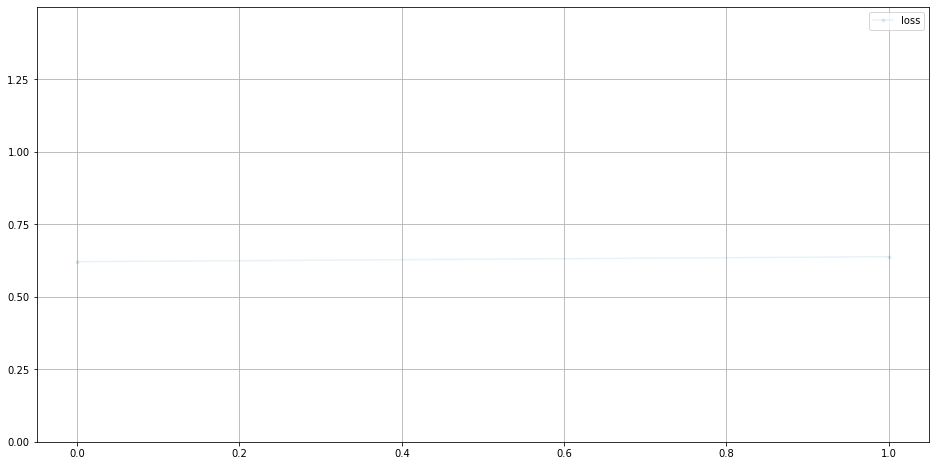

In [10]:
plot_progress()

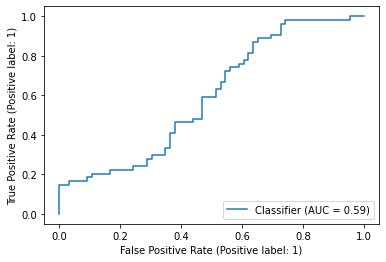

In [11]:
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_predictions(y_trues, y_preds)

In [17]:
y_preds = []
y_trues = []

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        image, label, _ = data

        if torch.cuda.is_available():
          image = image.cuda()
          label = label.cuda()

        prediction = model.forward(image.float()).squeeze(0)

        probas = torch.sigmoid(prediction)

        y_trues.append(int(label[0]))
        y_preds.append(probas[0].item())

    auc = metrics.accuracy_score(y_trues, y_preds)


print(f'AUC: ', auc)

ValueError: ignored

In [19]:
y_preds

[0.26331794261932373,
 0.25941556692123413,
 0.21371717751026154,
 0.3099943697452545,
 0.2716691493988037,
 0.3409633934497833,
 0.28668007254600525,
 0.33195143938064575,
 0.12953218817710876,
 0.18861719965934753,
 0.24078482389450073,
 0.3276415169239044,
 0.31805703043937683,
 0.268174409866333,
 0.17400147020816803,
 0.35850009322166443,
 0.23837530612945557,
 0.22408360242843628,
 0.24774610996246338,
 0.2648366391658783,
 0.27038276195526123,
 0.21093235909938812,
 0.17963626980781555,
 0.298137366771698,
 0.37289196252822876,
 0.22113661468029022,
 0.23982948064804077,
 0.31004706025123596,
 0.14304955303668976,
 0.23640821874141693,
 0.36943140625953674,
 0.2466859221458435,
 0.1766291707754135,
 0.1945122331380844,
 0.23233990371227264,
 0.28200122714042664,
 0.30755582451820374,
 0.24943411350250244,
 0.24709132313728333,
 0.243154376745224,
 0.38540583848953247,
 0.34793519973754883,
 0.20296038687229156,
 0.2864435911178589,
 0.2204871028661728,
 0.2895570695400238,
 0.20